# Should this loan be approved or not?

### Import Data & Library

In [617]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline

In [618]:
pd.set_option('display.max_columns', None)

In [619]:
SBA = pd.read_csv(r"C:\Users\ADMIN\Downloads\SBA_cleaned.csv", na_values='nan', index_col=None)
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,2.0,N,Y,P I F,0.80,0
1,72,60,2,2.0,N,Y,P I F,0.80,0
2,62,180,7,1.0,N,N,P I F,0.75,0
3,31-33,120,19,1.0,N,N,P I F,0.75,0
4,81,84,1,2.0,N,Y,P I F,0.80,0


### Preprocessing

#### Handle outliers

"According to the SBA, a small businesses have a maximum of anywhere between 250 and 1500 employees— all depending on the specific industry the business is in. Additionally, businesses have revenue limits that they must not exceed if they want to qualify for SBA financing. In general, companies with more than 1500 employees are not eligible for SBA loans." 

References: https://www.sba7a.loans/sba-7a-loans-small-business-blog/small-business-definition

In [620]:
SBA[SBA['NoEmp'] > 1500].value_counts().sum() # 72, a very small portion of the data, so we can drop these rows
SBA = SBA[SBA['NoEmp'] < 1500]

#### Encode categorical variables

In [621]:
# Label encoding for the NewExist, RevLineCr, LowDoc, MIS_Status columns
label_encoder = LabelEncoder()

# Apply label encoding to the 'NewExist' column
SBA['NewExist'] = label_encoder.fit_transform(SBA['NewExist']) # 0: Existing business, 1: New business

# Apply label encoding to the 'RevLineCr' column
SBA['RevLineCr'] = label_encoder.fit_transform(SBA['RevLineCr']) # 0: N, 1: Y

# Apply label encoding to the 'LowDoc' column
SBA['LowDoc'] = label_encoder.fit_transform(SBA['LowDoc']) # 0: N, 1: Y

# Apply label encoding to the 'MIS_Status' column
SBA['MIS_Status'] = label_encoder.fit_transform(SBA['MIS_Status']) # 0: CHGOFF, 1: P I F

In [622]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


#### Normalize `Term` and `NoEmp`

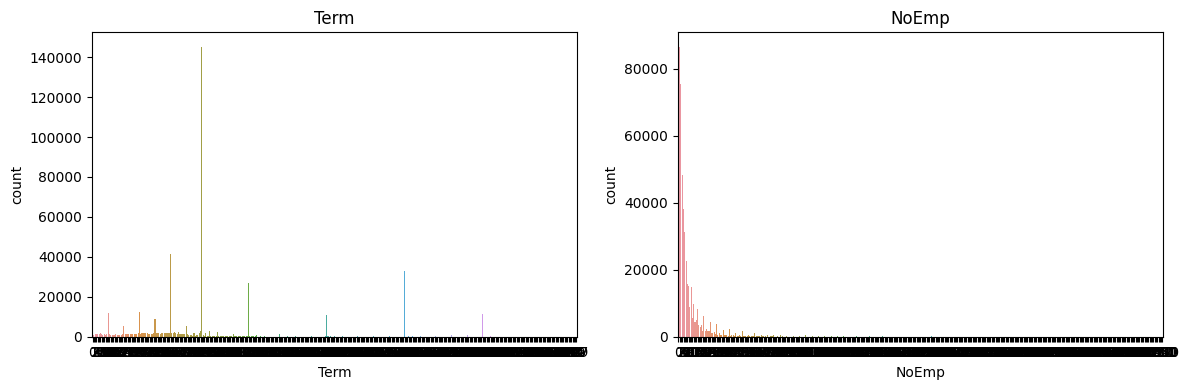

In [623]:
# Visualize the Term and NoEmp columns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=SBA, x='Term')
plt.title('Term')

plt.subplot(1, 2, 2)
sns.countplot(data=SBA, x='NoEmp')
plt.title('NoEmp')

plt.tight_layout()
plt.show()

In [624]:
# minmax = MinMaxScaler()
# SBAnorm = pd.DataFrame(minmax.fit_transform(SBA[['Term', 'NoEmp']]), columns=['Term', 'NoEmp'])
SBA.drop(['RevLineCr'], axis=1, inplace=True)
# SBA = pd.concat([SBA, SBAnorm], axis=1)

#### Handle `NAISC` column

In [625]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,1,1,0.80,0
1,72,60,2,1,1,1,0.80,0
2,62,180,7,0,0,1,0.75,0
3,31-33,120,19,0,0,1,0.75,0
4,81,84,1,1,1,1,0.80,0


In [626]:
# NAICScol = pd.get_dummies(SBA['NAICS'], prefix='NAICS', drop_first=False)

In [627]:
# SBA = pd.concat([SBA, NAICScol], axis=1)
# SBA.drop('NAICS', axis=1, inplace=True)

In [628]:
SBA['MIS_Status'].unique()

array([1, 0])

In [629]:
SBA = SBA.replace({True: 1, False: 0})

In [630]:
SBA = SBA.dropna()

In [631]:
SBA.shape

(459432, 8)

In [632]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,1,1,0.80,0
1,72,60,2,1,1,1,0.80,0
2,62,180,7,0,0,1,0.75,0
3,31-33,120,19,0,0,1,0.75,0
4,81,84,1,1,1,1,0.80,0


In [633]:
# import category_encoders as ce
# from sklearn.compose import make_column_transformer
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pandas as pd

# features = ['NAICS', 'Term', 'NoEmp', 'NewExist', 'RealEstate', 'LowDoc', 'SBA_GrPortion']

# # Prepare input data
# X = SBA[features]
# y = SBA['MIS_Status']

# knn = KNeighborsClassifier(n_neighbors=13)

# # Get 5000 samples for each value of 'MIS_Status'
# sample_size_per_class = 25000
# random_state = 12

# df_sampled = pd.concat([
#     group.sample(n=sample_size_per_class, random_state=random_state)
#     for _, group in SBA.groupby('MIS_Status')
# ])

# # Shuffle DataFrame 
# df_sampled = df_sampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

# X_sampled = df_sampled[features]
# y_sampled = df_sampled['MIS_Status']

# # Use binary encoder for the 'NAICS' column
# binary_encoder = ce.BinaryEncoder()
# ct = make_column_transformer((binary_encoder, ['NAICS']), remainder='passthrough')

# # Build the pipeline
# pipe = make_pipeline(ct, knn)

# # Fit the model
# pipe.fit(X_sampled, y_sampled)

# # Evaluate the model using cross-validation and calculate the average accuracy
# accuracy_mean = cross_val_score(pipe, X_sampled, y_sampled, cv=10, scoring='accuracy', n_jobs=-1).mean()

# # Print the evaluation result
# print(f"Average Accuracy: {accuracy_mean:.2f}")

# # Calculate evaluation metrics on the test set
# y_pred = pipe.predict(X_sampled)
# acc = accuracy_score(y_sampled, y_pred)
# prec = precision_score(y_sampled, y_pred, average='weighted', pos_label=0)
# rec = recall_score(y_sampled, y_pred, average='weighted', pos_label=0)
# f1 = f1_score(y_sampled, y_pred, average='weighted', pos_label=0)

# # Print the evaluation metrics
# print(f'Accuracy: {acc:.2f}')
# print(f'Precision: {prec:.2f}')
# print(f'Recall: {rec:.2f}')
# print(f'F1-score: {f1:.2f}')


In [634]:
# ENCODE NAICS
import category_encoders as ce
naics_column = SBA['NAICS']
binary_encoder = ce.BinaryEncoder(cols=['NAICS'])
encoded_naics = binary_encoder.fit_transform(naics_column)
SBA = pd.concat([SBA, encoded_naics], axis=1)
SBA.drop(['NAICS'], axis=1, inplace=True)
SBA

,Term,NoEmp,NewExist,LowDoc,MIS_Status,SBA_GrPortion,RealEstate,NAICS_0,NAICS_1,NAICS_2,NAICS_3,NAICS_4
0,84,4,1,1,1,0.80,0,0,0,0,0,1
1,60,2,1,1,1,0.80,0,0,0,0,1,0
2,180,7,0,0,1,0.75,0,0,0,0,1,1
3,120,19,0,0,1,0.75,0,0,0,1,0,0
4,84,1,1,1,1,0.80,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
459502,60,5,0,0,1,0.50,0,0,0,1,1,0
459503,240,8,0,0,1,1.00,1,0,0,1,0,0
459504,36,40,0,0,1,0.75,0,0,0,1,0,0
459505,60,6,0,0,1,0.50,0,0,0,0,0,1


### Set Up Before Modelling

In [635]:
features = ['Term', 'NoEmp' ,'NewExist','RealEstate','LowDoc','SBA_GrPortion', 'NAICS_0', 'NAICS_1','NAICS_2','NAICS_3','NAICS_4']
# Prepare inputs 
X = SBA[features]
y = SBA['MIS_Status']

In [636]:
# Get 5000 samples for each value of 'MIS_Status'
sample_size_per_class = 25000
random_state = 12

df_sampled = pd.concat([
    group.sample(n=sample_size_per_class, random_state=random_state)
    for _, group in SBA.groupby('MIS_Status')
])

# Shuffle DataFrame 
df_sampled = df_sampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

X_sampled = df_sampled[features]
y_sampled = df_sampled['MIS_Status']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.25, random_state=100)


### F1 Score from All Algorithms

**We will use several algorithms for this binary classification, which are :**
1. Logistic Regression
2. Decision Tree
3. Random Forest
5. KNN

**Objective :** Find the best F1_Score with cross_val_method

In [637]:
# F1 Score from Normal Train Data
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
algorithm = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier]
algo_name = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','KNeighborsClassifier']
F1Score = []

for item in algorithm:
  model = item()
  F1Scores = cross_val_score(model,X_train,y_train,cv=5,scoring='f1').mean()
  F1Score.append(F1Scores)

results = pd.DataFrame({
    'Algorithm' : algo_name,
    'F1 Score' : F1Score,
})

results

,Algorithm,F1 Score
0,LogisticRegression,0.795233
1,DecisionTreeClassifier,0.881157
2,RandomForestClassifier,0.892896
3,KNeighborsClassifier,0.890618


### Random Forest

In [638]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')  
    rec = recall_score(y_true, y_pred, average='weighted')   
    f1 = f1_score(y_true, y_pred, average='weighted')         
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

# Modelling and fitting with RandomForestClassifier
rf = RandomForestClassifier(random_state=12)
rf.fit(X_train, y_train)
prediction_rf = rf.predict(X_test)

# Evaluation using the metrics function
metrics(y_test, prediction_rf)


Accuracy: 0.8916
Precision: 0.8916
Recall: 0.8916
F1-score: 0.8916
tn :  5547  fp :  711  fn :  644  tp :  5598


### KNN

In [639]:
from tqdm.notebook import tqdm
from tqdm import tqdm

100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


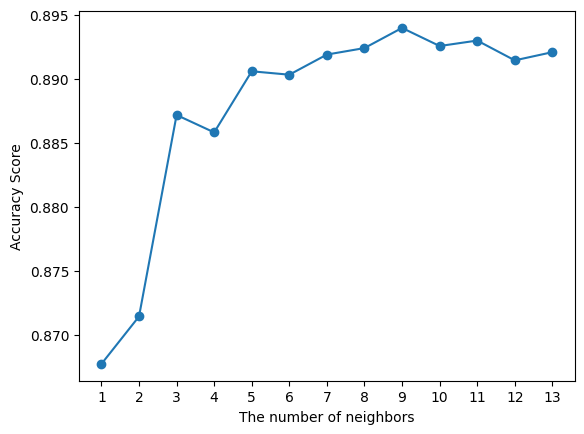

In [640]:
k_range = range(1,14 )
acc_scores = []

for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=5).mean()
    acc_scores.append(score)

plt.plot(k_range, acc_scores, marker='o')
plt.xlabel('The number of neighbors')
plt.ylabel('Accuracy Score')
plt.xticks(range(1, 14))
plt.show()

In [641]:

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1-score: {f1:.4f}')
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print('tn : ',tn, ' fp : ',fp,' fn : ' ,fn,' tp : ' ,tp)

# Modelling and fitting with KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(X_train, y_train)

# predicting
prediction_knn = knn.predict(X_test)

# Evaluation using the metrics function
metrics(y_test, prediction_knn)

Accuracy: 0.8946
Precision: 0.8947
Recall: 0.8946
F1-score: 0.8946
tn :  5565  fp :  693  fn :  624  tp :  5618
